# Solar Power Generation Data
## Semester project in TK8117

This project considers data from two solar powerplants, collected over a 34-day period. For the sake of this exercise the two powerplants are named Powerplant **Alpha** and Powerplant **Charlie**. For the solar powerplants there are several areas of concern:

* Can we predict the power generation for next couple of days?
* Can we predict the power generation of a plant, based on environmental sensor measurements in and around the plant?
* Can we identify the need for panel cleaning/maintenance?
* Can we identify faulty or suboptimally performing equipment?



In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

base_time = pd.Timestamp('2020-05-15')

## Import and first look at the Generator Data

The data for each powerplant is split into two tables. We will begin by looking at the two files from powerplant **Alpha**. The two tables are:

* ```Plant_Alpha_Generation_Data ``` Containing data about the power generation of the powerplant sampled at 15-minute intervals


* ```Plant_Alpha_Weather_Sensor_Data ``` Containing data about the weather conditions at the plant, as well as some sensor data from some intrinsic sensors in the powerplant 

Lets first have a look at the generation data from powerplant **Alpha**:


In [58]:
alpha_gen_data_path = 'dataset/Plant_Alpha_Generation_Data.csv'
alpha_gen_raw_data = pd.read_csv(alpha_gen_data_path, parse_dates=["DATE_TIME"])

alpha_gen_raw_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


The data quite well behaved, but needs some structuring. The dataset contains some data which is not of interest to us:

* ```PLANT_ID``` Refers is a unique identifier for plant **Alpha** and remains the same throughout the dataset. 
* ```SOURCE_KEY``` Is a unique identifier for each data row, and is intended to be unique and random

As these collumns does not give us any useful information for data analysis, they are removed from the dataset

The remaining colums provide useful data, and can be explained as such:

* ```DATE_TIME``` Shows the time and date of the measurement. The measurements from the powerplant are done at intervals of 15 minutes *Note that the date and time are not unique for each row. There are multiple measurements every 15 minute interval, which vary in quantity*
* ```DC_POWER``` Is the DC power produced by the plant at the given timestamp in kW
* ```AC_POWER``` Is the AC power produced by the plant at the given timestamp in kW
* ```DAILY_YIELD``` Is a cumulative measure of the power produced throughout the day. The daily yield resets to zero at midnight
* ```TOTAL_YIELD``` Gives the total yield for the inverter till that point in time.



In [50]:
alpha_gen_fields = ["DATE_TIME", "DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD"]

We pull the data from the file ```Plant_Alpha_Generation_Data ``` again, importing only the columns we need. When looking at the first few columns of data, we see that the ```DC_POWER```, ```AC_POWER``` and ```DAILY_YIELD``` fields are zero, which intuitively makes sense, as the data recording starts at midnight May 15th when the sun has set and the powerplant does not produce any power.

Lets look at some more interesting data from around 11:30 later on the same day:

In [56]:
alpha_gen_data = pd.read_csv(alpha_gen_data_path, parse_dates=["DATE_TIME"], usecols=gen_fields)

alpha_gen_data[990:1020]

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
990,2020-05-15 11:15:00,8240.000000,805.550000,2271.375000,6341651.375
991,2020-05-15 11:15:00,8617.500000,842.275000,1922.250000,7118073.250
992,2020-05-15 11:30:00,6226.125000,609.862500,1994.500000,6261553.500
993,2020-05-15 11:30:00,7405.285714,724.442857,2377.571429,6186022.571
994,2020-05-15 11:30:00,8226.857143,803.671429,2295.857143,6990054.857
995,2020-05-15 11:30:00,7328.000000,716.928571,2242.000000,7605202.000
996,2020-05-15 11:30:00,6471.285714,633.857143,2518.714286,7161482.714
997,2020-05-15 11:30:00,7761.142857,759.214286,2252.285714,7208660.286
998,2020-05-15 11:30:00,8600.571429,840.085714,2217.000000,7030890.000
999,2020-05-15 11:30:00,6340.500000,621.012500,2394.875000,7182360.875


In [2]:
sensor_fields = ["DATE_TIME", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]

sensor_data_path = 'dataset/Plant_1_Weather_Sensor_Data.csv'

sensor_data = pd.read_csv(sensor_data_path, parse_dates=["DATE_TIME"], usecols=sensor_fields)

sensor_data

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,24.621525,22.165423,0.0
...,...,...,...,...
3177,2020-06-17 22:45:00,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,21.969495,20.734963,0.0


In [3]:
gen_fields = ["DATE_TIME", "DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD"]
gen_data_path = 'dataset/Plant_1_Generation_Data.csv'
gen_data = pd.read_csv(gen_data_path, parse_dates=["DATE_TIME"], usecols=gen_fields)

gen_data["TIME_OF_DAY"] = gen_data["DATE_TIME"].dt.time
gen_data["MINUTES_PAST_MIDNIGHT"] = gen_data.apply(lambda x: int((x["DATE_TIME"] - base_time).seconds/60), axis=1)

gen_data

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,TIME_OF_DAY,MINUTES_PAST_MIDNIGHT
0,2020-05-15 00:00:00,0.0,0.0,0.000,6259559.0,00:00:00,0
1,2020-05-15 00:00:00,0.0,0.0,0.000,6183645.0,00:00:00,0
2,2020-05-15 00:00:00,0.0,0.0,0.000,6987759.0,00:00:00,0
3,2020-05-15 00:00:00,0.0,0.0,0.000,7602960.0,00:00:00,0
4,2020-05-15 00:00:00,0.0,0.0,0.000,7158964.0,00:00:00,0
...,...,...,...,...,...,...,...
68773,2020-06-17 23:45:00,0.0,0.0,5967.000,7287002.0,23:45:00,1425
68774,2020-06-17 23:45:00,0.0,0.0,5147.625,7028601.0,23:45:00,1425
68775,2020-06-17 23:45:00,0.0,0.0,5819.000,7251204.0,23:45:00,1425
68776,2020-06-17 23:45:00,0.0,0.0,5817.000,6583369.0,23:45:00,1425


In [4]:
data = pd.merge(sensor_data, gen_data, on="DATE_TIME")
data

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,TIME_OF_DAY,MINUTES_PAST_MIDNIGHT
0,2020-05-15 00:00:00,25.184316,22.857507,0.0,0.0,0.0,0.000,6259559.0,00:00:00,0
1,2020-05-15 00:00:00,25.184316,22.857507,0.0,0.0,0.0,0.000,6183645.0,00:00:00,0
2,2020-05-15 00:00:00,25.184316,22.857507,0.0,0.0,0.0,0.000,6987759.0,00:00:00,0
3,2020-05-15 00:00:00,25.184316,22.857507,0.0,0.0,0.0,0.000,7602960.0,00:00:00,0
4,2020-05-15 00:00:00,25.184316,22.857507,0.0,0.0,0.0,0.000,7158964.0,00:00:00,0
...,...,...,...,...,...,...,...,...,...,...
45675,2020-06-17 23:45:00,21.909288,20.427972,0.0,0.0,0.0,5967.000,7287002.0,23:45:00,1425
45676,2020-06-17 23:45:00,21.909288,20.427972,0.0,0.0,0.0,5147.625,7028601.0,23:45:00,1425
45677,2020-06-17 23:45:00,21.909288,20.427972,0.0,0.0,0.0,5819.000,7251204.0,23:45:00,1425
45678,2020-06-17 23:45:00,21.909288,20.427972,0.0,0.0,0.0,5817.000,6583369.0,23:45:00,1425


<AxesSubplot:>

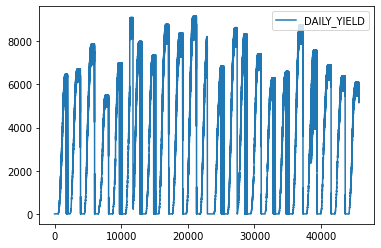

In [5]:
data.plot(y=["DAILY_YIELD"])

In [6]:
features = ["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "MINUTES_PAST_MIDNIGHT"]

# PCA on only "DC_POWER", "AC_POWER", "DAILY_YIELD"
# PCA on only "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"
# PLSR
# L1 reguralization

x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=5)
pca.fit(x)
pca.components_

array([[ 0.4506841 ,  0.45070923,  0.12652202, -0.00512159,  0.39574088,
         0.46036514,  0.44998413,  0.08172121],
       [-0.14697489, -0.14698764,  0.66711557,  0.00107741,  0.20864602,
        -0.04720634, -0.14930274,  0.66610492],
       [ 0.01869462,  0.01867163,  0.00904847,  0.99871526, -0.03918483,
        -0.00551423,  0.00940122,  0.01155797],
       [-0.2344038 , -0.23375718,  0.13240997,  0.04519708,  0.73937596,
         0.10098392, -0.22845712, -0.51163468],
       [-0.11625545, -0.11514099, -0.72121192,  0.02111464,  0.38304769,
         0.09467038, -0.09634624,  0.53634332]])

In [7]:
np.cumsum(pca.explained_variance_ratio_)

array([0.57583822, 0.81474815, 0.93996639, 0.97928642, 0.99611623])

<AxesSubplot:xlabel='IRRADIATION', ylabel='DC_POWER'>

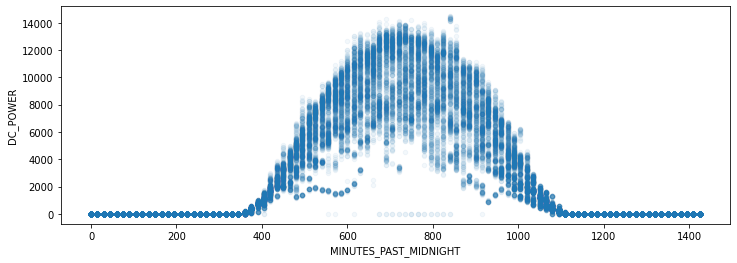

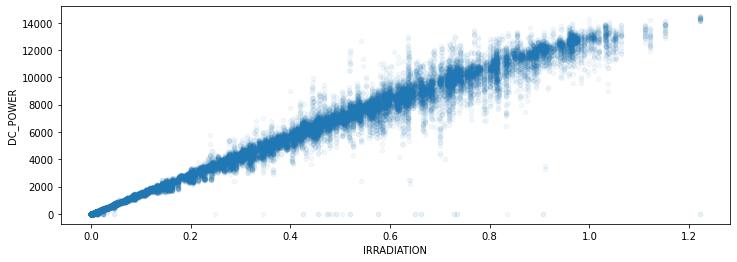

In [35]:
data.plot.scatter(x="MINUTES_PAST_MIDNIGHT", y="DC_POWER", alpha=0.05, figsize = (12,4))
data.plot.scatter(x="IRRADIATION", y="DC_POWER", alpha=0.05, figsize = (12,4))